In [1]:
# import sys
# from pyspark import SparkContext
# from pyspark.streaming import StreamingContext
# import nltk
# import heapq
# import numpy as np
# import datetime
# import json
# from pyspark.mllib.linalg import Vectors
# import math
# import string
# from nltk.corpus import stopwords, wordnet
# from collections import Counter
# from pyspark.mllib.clustering import LDA, LDAModel
# import heapq
# import time

In [ ]:
# # interval is the window interval in minutes
# def write_file(topic_word_list, sample_tweet, interval):
#     localtime = time.asctime(time.localtime(time.time()))
#     file_name = get_file_name(localtime, interval)
#     topic_number = len(topic_word_list)
#     data_to_write = {'topic_number': topic_number, 'topics': {}, 'sample_tweet': {}}
#     for i in range(topic_number):
#         data_to_write['topics']['topic_'+str(i)] = topic_word_list[i]
#         data_to_write['sample_tweet']['topic_'+str(i)] = sample_tweet[i]
# #     print(data_to_write)
#     write_file = open(file_name, 'w')
#     write_file.write(str(data_to_write))
#     write_file.close()

# def get_file_name(localtime, interval):
#     time_stamp = localtime.split(' ')
#     tmp = time_stamp[4].split(':')
#     hour_minute = tmp[0]+':'+str(int(int(tmp[1])/interval)*interval)
#     return '_'.join([time_stamp[1], time_stamp[3], hour_minute, time_stamp[5]])+'.txt'

In [1]:
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import nltk
import heapq
import numpy as np
import datetime
import json
from pyspark.mllib.linalg import Vectors
import math
import string
from nltk.corpus import stopwords, wordnet
from collections import Counter
from pyspark.mllib.clustering import LDA, LDAModel
import heapq
import pandas as pd

def preprocess():
    words = stopwords.words('english')
    for w in ['!',',','.','?','-s','-ly','</s>','s','@','&','$','#']:
        words.append(w)
    return words
#     filtered_words = [word for word in (line for line in text) if word not in words]
#     return filter_words

def get_tokens(text):
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    return tokens

# def write_log(x):
#     logfile = "log"
#     with open(logfile,"a") as f:
#         f.write(x)
#         f.write('\n')
#     return x

def main(x):
    
    rst = []
    for i in range(len(x[1])):
        if i%4 != 3:
            continue
        else:
            rst.append([i/4+1, [x[1][i]]])
    return rst

def main2(rst, interval):
    
    import nltk
    import heapq
    import numpy as np
    import datetime
    import json
    from pyspark.mllib.linalg import Vectors
    import math
    import string
    from nltk.corpus import stopwords, wordnet
    from collections import Counter
    from pyspark.mllib.clustering import LDA, LDAModel
    import heapq
    import pandas as pd
    import time
    import matplotlib.pyplot as plt
    
    stop_words = stopwords.words('english')
    for w in ['!',',','.','?','-s','-ly','</s>','s','@','&','$','#']:
        stop_words.append(w)
    
    sno = nltk.stem.SnowballStemmer('english')
    all_words = []
    
    if rst == None:
        return [1,2,3]
    
    for entry in rst:
        all_words += get_tokens(entry[1][0])
    
    all_words = [word for word in all_words if word not in stop_words]
    all_words2 = [x for x in all_words if x[0:8] != u'httpstco'] 
    raw_wordlist = []
    
    for word in all_words2:
        if word.isalpha() == False or len(word) <= 3:
            continue
        word = sno.stem(word)
        if wordnet.synsets(word):  
            raw_wordlist.append(word)
    count = Counter(raw_wordlist)
    word_list = count.most_common(int(math.floor(0.5*len(count))))
    
    dictionary2 = {}
    for i in range(len(word_list)):
        dictionary2[i] = word_list[i][0]
    print "The length of my dictionary2 is  ", len(dictionary2)
    dictionary = {}
    for i in range(len(word_list)):
        dictionary[word_list[i][0]] = (i,word_list[i][1])
    
    
    
    line = []
    bigMatrix = []
    
    for entry in rst:
        line = get_tokens(entry[1][0])
        temp = np.zeros(shape=(1,len(word_list)))
        ######################### rebuild the rst
#         line = [word for word in line if word not in stop_words]
#         line = [word for word in line if word[0:8] != u'httpstco']
        #########################
        for word in line:
            word = sno.stem(word)
            if(wordnet.synsets(word)):
                if word in dictionary:
                    temp[0][dictionary[word][0]] += 1
        bigMatrix.append(temp[0])
    
    Matrix = np.array(bigMatrix) 
    ############################################
    
    X = Matrix.T
    K = 5
    T = 100
    def LDA(X, K, T, n, dictionary):
        W = np.random.random((X.shape[0], K)) + 1
        H = np.random.random((K, X.shape[1])) + 1
        for i in range(T):

            print(i)
            temp = X/(W.dot(H) + 10 ** -16)

            #s = W.sum(axis = 0)
            W_t_n = W.T/W.sum(axis = 0).reshape(1,-1).T
            H = H * W_t_n.dot(temp)

            temp = X/(W.dot(H) + 10 ** -16)

        #s = H.sum(axis = 1)
            H_t_n = H.T/H.sum(axis = 1).reshape(1,-1)
            W = W * temp.dot(H_t_n)
        #temp = W.dot(H) + 10 ** - 16
        #diff = -X * np.log(temp) + temp
        #f.append(diff.sum())
        W_n = W.T/W.sum(axis = 0).reshape(1,-1).T
        topics = []
        for i in range(K):
            topics.append(heapq.nlargest(n, range(len(W_n[i])), W_n[i].take))
    
        topic_words_list = []

        for i in range(K):
            topic_words = []
            for index in topics[i]:
                #topic_words.append(np.array([dictionary[index], round(W_n[i][index], 4)]))
                topic_words.append([dictionary[index].encode('utf-8'), round(W_n[i][index], 4)])
            topic_words_list.append(topic_words)
        
        samples = []
        for i in range(K):
            samples.append(heapq.nlargest(1, range(len(H[i])), H[i].take))
        
        sample_tweet = []
        
        ###
        for index in samples:
            sample_tweet.append(rst[index[0]][1][0].encode('utf-8'))
            #sample_tweet.append(rst[0][1][0])
        
        return W, H, topics, W_n.shape, topic_words_list, sample_tweet, H.shape, X.shape
        
    def get_file_name(localtime, interval):
        time_stamp = localtime.split(' ')
        tmp = time_stamp[4].split(':')
        if int(time_stamp[3]) < 10:
            time_stamp[3] = '0' + time_stamp[3]
        if int(tmp[0]) < 10:
            tmp[0] = '0' + tmp[0]
        if int(int(tmp[1])/interval)*interval < 10:
            hour_minute = tmp[0] + '|0' + str(int(int(tmp[1])/interval)*interval)
        else:
            hour_minute = tmp[0]+'|'+str(int(int(tmp[1])/interval)*interval)
        return '_'.join([time_stamp[1], time_stamp[3], hour_minute, time_stamp[5]])+'.txt'
    
    def write_file(topic_word_list, sample_tweet, interval):
        localtime = time.asctime(time.localtime(time.time()))
        file_name = get_file_name(localtime, interval)
        topic_number = len(topic_word_list)
        data_to_write = {'topic_number': topic_number, 'topics': {}, 'sample_tweet': {}}
        for i in range(topic_number):
            data_to_write['topics']['topic_'+str(i)] = topic_word_list[i]
            data_to_write['sample_tweet']['topic_'+str(i)] = sample_tweet[i]
    #     print(data_to_write)
        write_file = open(file_name, 'w')
        write_file.write(str(data_to_write))
        write_file.close()
        
        
    if(len(X)==0):
        return rst
    
    # interval is the window interval in minutes
    lda_return = LDA(X, K, T, min(5,int(len(dictionary2))), dictionary2)
    write_file(lda_return[4], lda_return[5], interval)
    
    ###############
    
#     H = lda_return[1]
#     v = H.sum(axis = 1)
#     topic_sort = np.argsort(-v)
#     plt.bar(range(K), v)
#     plt.xticks(range(K), lda_return[4][:,0,0])
#     plt.savefig("Topic_bar", dpi = 600)
    
    
    #################
    
    
    #return [dictionary2,topics]
    
    return [rst,lda_return[6],lda_return[7]]
    

if __name__ == "__main__":

    batch_interval = 1 # base time unit (in seconds)
    window_length = 10 * batch_interval
    frequency = 2 * batch_interval
    try:
        stc.stop()  
    except: 
        pass
    try:
        spc.stop()  
    except: 
        pass
    
    spc = SparkContext(appName="OnlineLDA")
    stc = StreamingContext(spc, batch_interval)
    stc.checkpoint("checkpoint")
    
#     stop_words =preprocess()
#     spc.broadcast(stop_words)
    
    lines = stc.socketTextStream('', 9000)
    windows = lines.window(window_length, frequency)
    
    #implement LDA algorithm
    line = windows.map(lambda x: (1,(2,x[12:]))).reduceByKey(lambda x,y: x+y).map(lambda x: main(x))\
    .map(lambda x:main2(x, frequency))
    line.pprint()
    stc.start()
    stc.awaitTermination()

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



KeyboardInterrupt: 

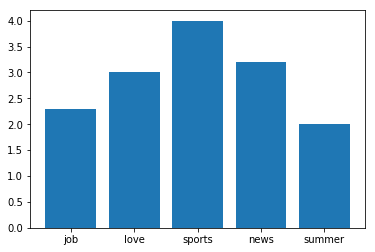

In [2]:
import matplotlib.pyplot as plt
# import numpy as np
i = range(5)
v = [2.3,3,4,3.2,2]

name_list = ['job','love','sports','news','summer']
plt.bar(i, v)
plt.xticks(i,name_list)

plt.show()
# ax.set_xticks(ind)  
# ax.set_xticklabels(name_list)  
# # labels  
# ax.set_xlabel('Country')
# ax.show()

In [22]:
x = [0,1,2,3]
y = [4,5,6,7]
x,y

([0, 1, 2, 3], [4, 5, 6, 7])

In [2]:
# def preprocess():
#     words = stopwords.words('english')
#     for w in ['!',',','.','?','-s','-ly','</s>','s','@','&','$','#']:
#         words.append(w)
    
#     filtered_words = [word for word in (line for line in text) if word not in words]
#     return filter_words

In [3]:
# def get_tokens(x):
#     lowers = x.lower()
#     #remove the punctuation using the character deletion step of translate
#     no_punctuation = lowers.translate(None, string.punctuation)
#     tokens = nltk.word_tokenize(no_punctuation)
#     return tokens

In [4]:
# def write_log(x):
#     logfile = "log"
#     with open(logfile,"a") as f:
#         f.write(x)
#         f.write('\n')
#     return x

In [5]:
# def main(x):
#     rst = []
#     for i in range(len(x[1])):
#         if i%4 != 3:
#             continue
#         else:
#             rst.append([i/3, [x[1][i]]])
    
#     filtered_words = preprocess()
#     sno = nltk.stem.SnowballStemmer('english')
#     all_words = []
#     for entry in rst:
#         all_words += get_tokens(entry[1][0])
#     all_words2 = [x for x in all_words if x[0:8] != u'httpstco']
#     raw_wordlist = [] 
#     for word in all_words2:
#         if word.isalpha() == False or len(word) <= 3:
#             continue
#         word = sno.stem(word)
#         if wordnet.synsets(word):  
#             raw_wordlist.append(word)
#     count = Counter(raw_wordlist)
#     word_list = count.most_common(round(0.5*len(count)))
    
#     dictionary2 = {}
#     for i in range(len(word_list)):
#         dictionary2[i] = word_list[i][0]
#     dictionary = {}
#     for i in range(math.ceil(0.5*len(count))):
#         dictionary[word_list[i][0]] = (i,word_list[i][1])

#     line = []
#     bigMatrix = []
    
#     for item in filtered_words:
#         temp = np.zeros(shape=(1,int(math.ceil(0.5*len(count)))))
#         line = get_tokens(item)
#         line = [word for word in line if word not in stopwords.words('english')]
#         line = [word for word in line if word[0:8] != u'httpstco']
#         for word in line:
#             word = sno.stem(word)
#             if(wordnet.synsets(word)):
#                 if word in dictionary:
#                     temp[0][dictionary[word][0]] += 1
#         bigMatrix.append(temp[0])
    
#     return bigMatrix

In [6]:
# # Sliding window for twitter
# if __name__ == "__main__":
# #     if len(sys.argv) != 3:
# #         raise IOError("Invalid usage; the correct format is:\nwindow_count.py <hostname> <port>")

#     batch_interval = 1 # base time unit (in seconds)
#     window_length = 10 * batch_interval
#     frequency = 2 * batch_interval
#     try:
#         stc.stop()  
#     except: 
#         pass
#     try:
#         spc.stop()  
#     except: 
#         pass
#     spc = SparkContext(appName="OnlineLDA")
#     stc = StreamingContext(spc, batch_interval)
#     stc.checkpoint("checkpoint")
    
#     lines = stc.socketTextStream('', 9001)
#     windows = lines.window(window_length, frequency)
    
#     #implement LDA algorithm
    
#     line = windows.map(lambda x: (1,(2,x[12:]))).reduceByKey(lambda x,y: x+y).map(lambda x: main(x))
#     #temp = windows.flatMap(lambda x: x[12:].strip().split(" "))\
#     #.map(lambda x: (x, 1))\
#     #.reduceByKey(lambda x,y: x + y)
    
#     #     temp = windows.flatMap(lambda x: x[12:].strip().split(' ')).filter(lambda x: x) \
# #                   .map(lambda x: (x, 1)) \
# #                   .reduceByKey(lambda x,y: x+y)
#             #.map(lambda x: A(x))
#             #.map(lambda x: word_clean(x)).filter(lambda x: x) \
#     #rdd = windows.map(lambda x:x.split(" ")).map(lambda x: A(x)).filter(lambda x: x is not None)
#     line.pprint()
#     stc.start()
#     stc.awaitTermination()

Py4JJavaError: An error occurred while calling o21.start.
: java.io.IOException: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/streaming/util.py", line 105, in dumps
    func.func, func.rdd_wrap_func, func.deserializers)))
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/serializers.py", line 464, in dumps
    return cloudpickle.dumps(obj, 2)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 704, in dumps
    cp.dump(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 148, in dump
    return Pickler.dump(self, obj)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 224, in dump
    self.save(obj)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 639, in _batch_appends
    save(x)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 639, in _batch_appends
    save(x)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 255, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 255, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 692, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 687, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 692, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 331, in save
    self.save_reduce(obj=obj, *rv)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 565, in save_reduce
    "args[0] from __newobj__ args has the wrong class")
PicklingError: args[0] from __newobj__ args has the wrong class

	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1310)
	at org.apache.spark.streaming.api.python.TransformFunction.writeObject(PythonDStream.scala:100)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1128)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1496)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1378)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1174)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.defaultWriteObject(ObjectOutputStream.java:441)
	at org.apache.spark.streaming.DStreamGraph$$anonfun$writeObject$1.apply$mcV$sp(DStreamGraph.scala:187)
	at org.apache.spark.streaming.DStreamGraph$$anonfun$writeObject$1.apply(DStreamGraph.scala:182)
	at org.apache.spark.streaming.DStreamGraph$$anonfun$writeObject$1.apply(DStreamGraph.scala:182)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1303)
	at org.apache.spark.streaming.DStreamGraph.writeObject(DStreamGraph.scala:182)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1128)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1496)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.streaming.Checkpoint$$anonfun$serialize$1.apply$mcV$sp(Checkpoint.scala:150)
	at org.apache.spark.streaming.Checkpoint$$anonfun$serialize$1.apply(Checkpoint.scala:150)
	at org.apache.spark.streaming.Checkpoint$$anonfun$serialize$1.apply(Checkpoint.scala:150)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1337)
	at org.apache.spark.streaming.Checkpoint$.serialize(Checkpoint.scala:151)
	at org.apache.spark.streaming.StreamingContext.validate(StreamingContext.scala:525)
	at org.apache.spark.streaming.StreamingContext.liftedTree1$1(StreamingContext.scala:573)
	at org.apache.spark.streaming.StreamingContext.start(StreamingContext.scala:572)
	at org.apache.spark.streaming.api.java.JavaStreamingContext.start(JavaStreamingContext.scala:556)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/streaming/util.py", line 105, in dumps
    func.func, func.rdd_wrap_func, func.deserializers)))
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/serializers.py", line 464, in dumps
    return cloudpickle.dumps(obj, 2)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 704, in dumps
    cp.dump(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 148, in dump
    return Pickler.dump(self, obj)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 224, in dump
    self.save(obj)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 639, in _batch_appends
    save(x)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 639, in _batch_appends
    save(x)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 255, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 255, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 642, in _batch_appends
    save(tmp[0])
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 692, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 687, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 249, in save_function
    self.save_function_tuple(obj)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 297, in save_function_tuple
    save(f_globals)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 655, in save_dict
    self._batch_setitems(obj.iteritems())
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 692, in _batch_setitems
    save(v)
  File "/Users/tingran/anaconda2/lib/python2.7/pickle.py", line 331, in save
    self.save_reduce(obj=obj, *rv)
  File "/Users/tingran/Documents/2017_2018AcademicYear/spark-2.2.1-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 565, in save_reduce
    "args[0] from __newobj__ args has the wrong class")
PicklingError: args[0] from __newobj__ args has the wrong class

	at org.apache.spark.streaming.api.python.PythonTransformFunctionSerializer$.serialize(PythonDStream.scala:144)
	at org.apache.spark.streaming.api.python.TransformFunction$$anonfun$writeObject$1.apply$mcV$sp(PythonDStream.scala:101)
	at org.apache.spark.streaming.api.python.TransformFunction$$anonfun$writeObject$1.apply(PythonDStream.scala:100)
	at org.apache.spark.streaming.api.python.TransformFunction$$anonfun$writeObject$1.apply(PythonDStream.scala:100)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1303)
	... 63 more


In [ ]:
#     stopWORD = preprocess()
#     sno = nltk.stem.SnowballStemmer('english')
#     all_words = []
#     for entry in rst:
#         lowers = entry[1][0].encode('utf-8').lower()
#         #remove the punctuation using the character deletion step of translate
#         no_punctuation = lowers.translate(None, string.punctuation)
#         tokens = nltk.word_tokenize(no_punctuation)
#         all_words += tokens
#     all_words2 = [x for x in all_words if x[0:8] != u'httpstco']
#     raw_wordlist = [] 
#     for word in all_words2:
#         if word.isalpha() == False or len(word) <= 3:
#             continue
#         word = sno.stem(word)
#         if wordnet.synsets(word):  
#             raw_wordlist.append(word)
#     count = Counter(raw_wordlist)
#     word_list = count.most_common(round(0.5*len(count)))
    
#     dictionary2 = {}
#     for i in range(len(word_list)):
#         dictionary2[i] = word_list[i][0]
#     dictionary = {}
#     for i in range(round(0.5*len(count))):
#         dictionary[word_list[i][0]] = (i,word_list[i][1])

#     line = []
#     bigMatrix = []
    
#     for item in filtered_words:
#         temp = np.zeros(shape=(1,round(0.5*len(count))))
#         line = get_tokens(item)
#         line = [word for word in line if word not in stopWORD]
#         line = [word for word in line if word[0:8] != u'httpstco']
#         for word in line:
#             word = sno.stem(word)
#             if(wordnet.synsets(word)):
#                 if word in dictionary:
#                     temp[0][dictionary[word][0]] += 1
#         bigMatrix.append(temp[0])
# Sliding window for twitter

In [2]:
# def A(x):
#     rst = []
#     if x[0] == u'{' or x[0] == u'}{':
#         return None
#     for item in x:
#         if item[0:6] == u'"text:"':
#             rst.append(item[7:])
#             continue
#         if item != u'':
#             rst.append(item)
#     return rst